In this Kaggle we are trying to predict retrospectively what was the sale price of a property based on a large number of features such as square footage, number of bedrooms, quality of the property and month of sale. The dataset is limited to one city from the state of Iowa and contains about 1.5k rows as training data. As ruled by Kaggle, we will use RMSE in order to assess the performance of our model. 

In [2]:
#Import packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
from xgboost import XGBRegressor

In [3]:
#Check python version and env
print(sys.version)

3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:14:12) [Clang 14.0.6 ]


In [4]:
#Pull data from file
df_train = pd.read_csv('house_price_train.csv')
df_submission = pd.read_csv('house_price_test.csv')

In [5]:
#Pull features from training dataset and its number of rows
print(df_train.columns)
print(len(df_train))

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

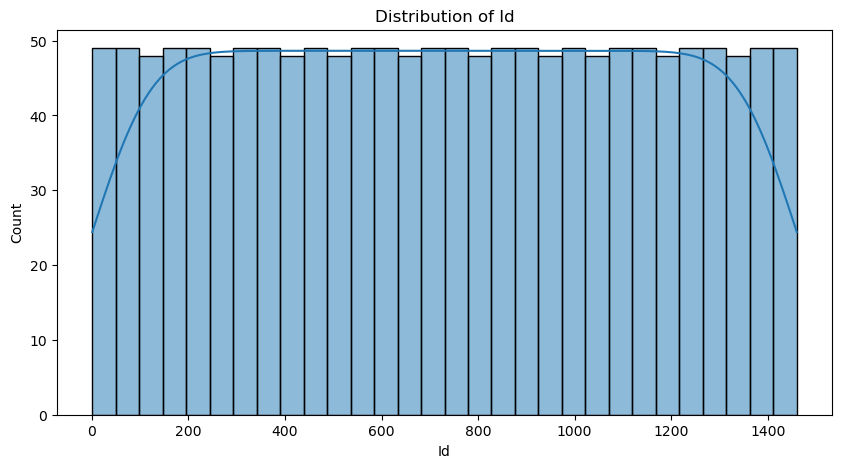

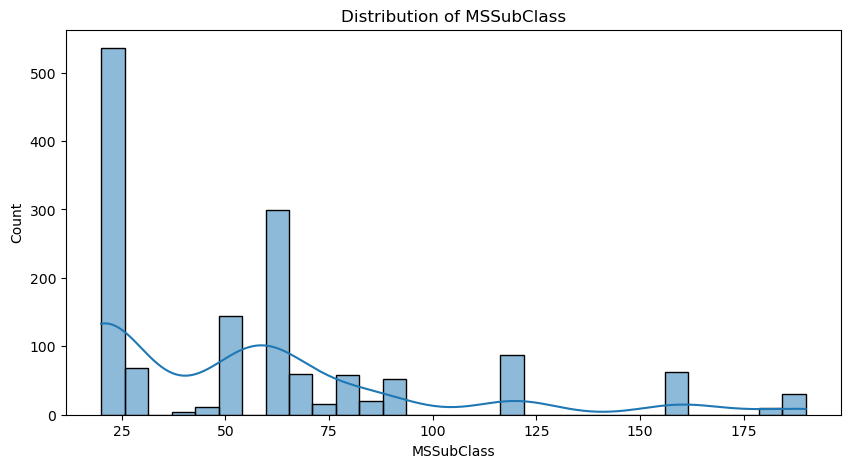

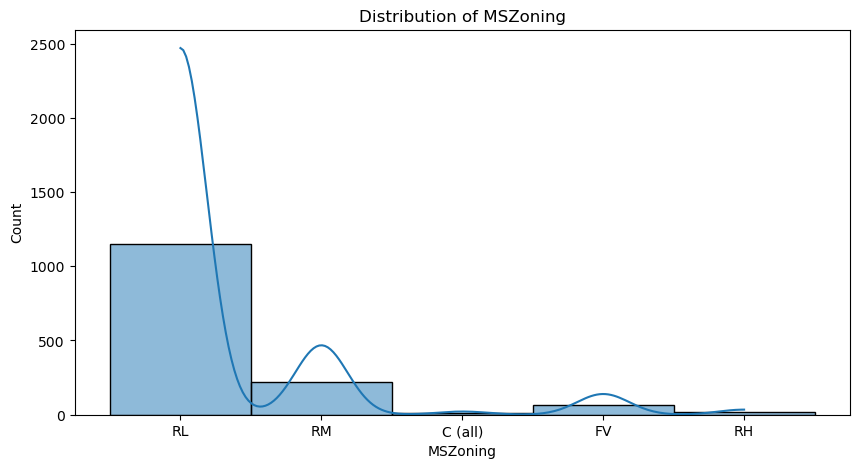

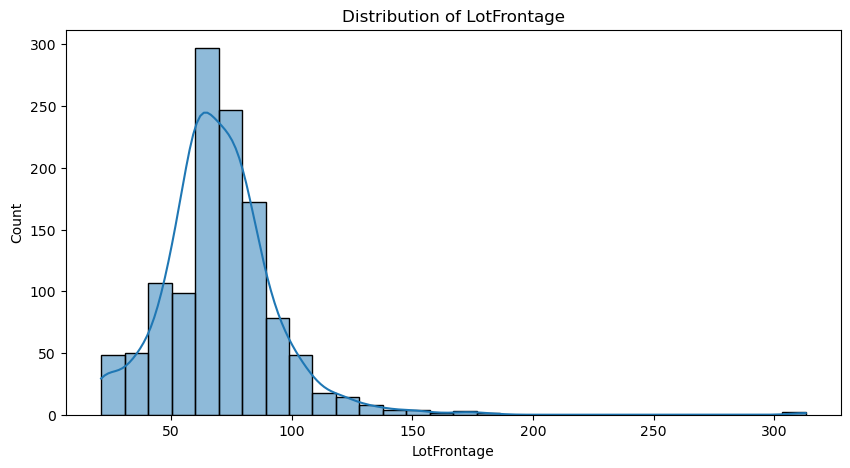

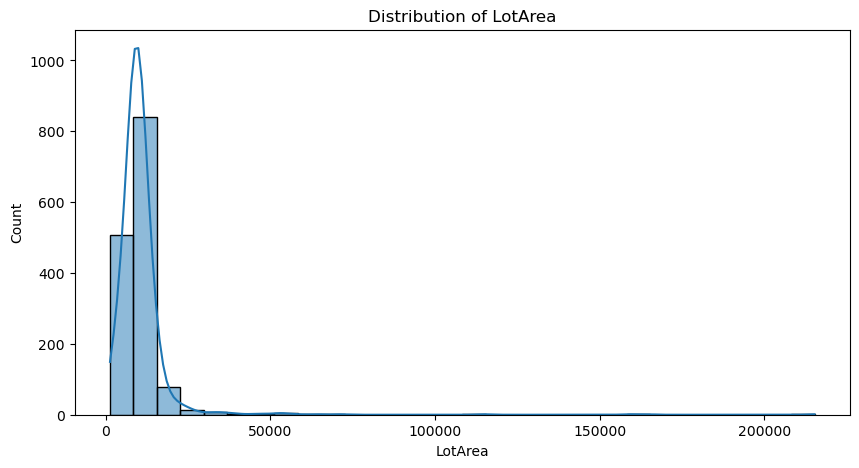

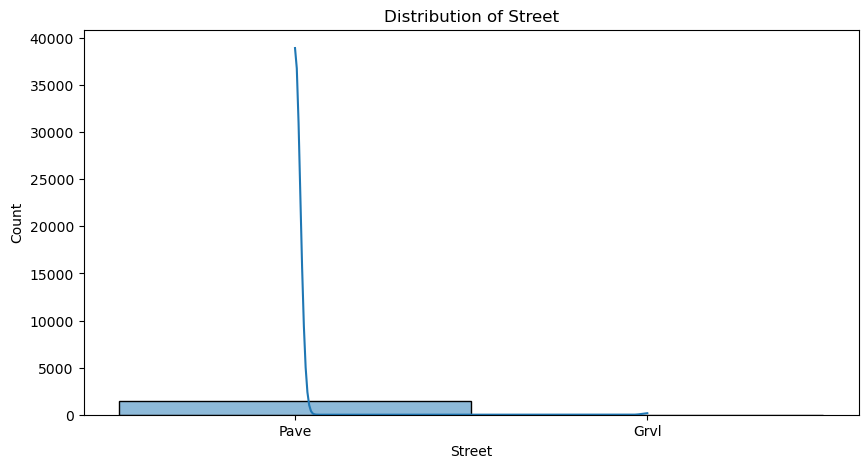

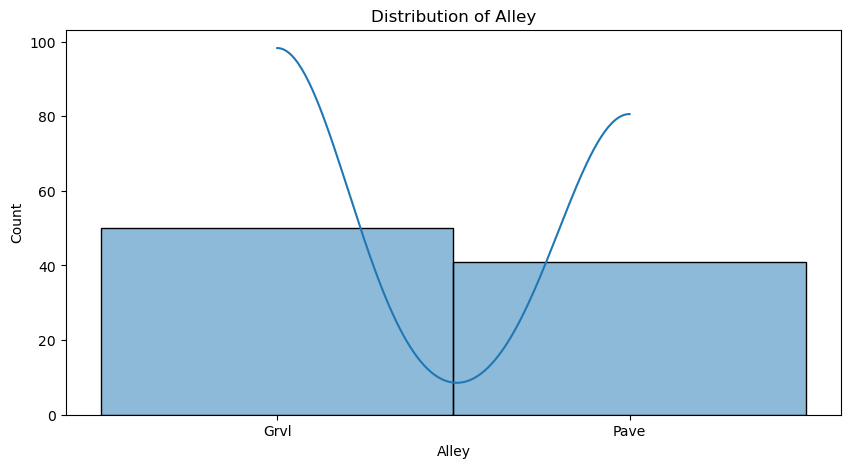

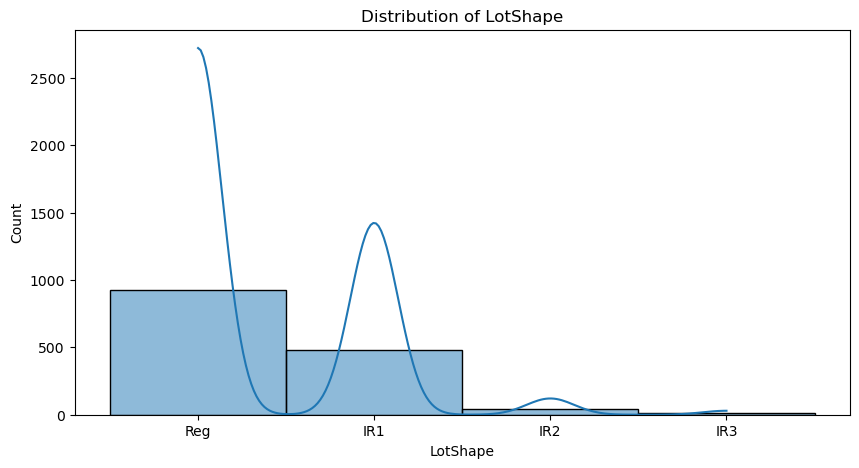

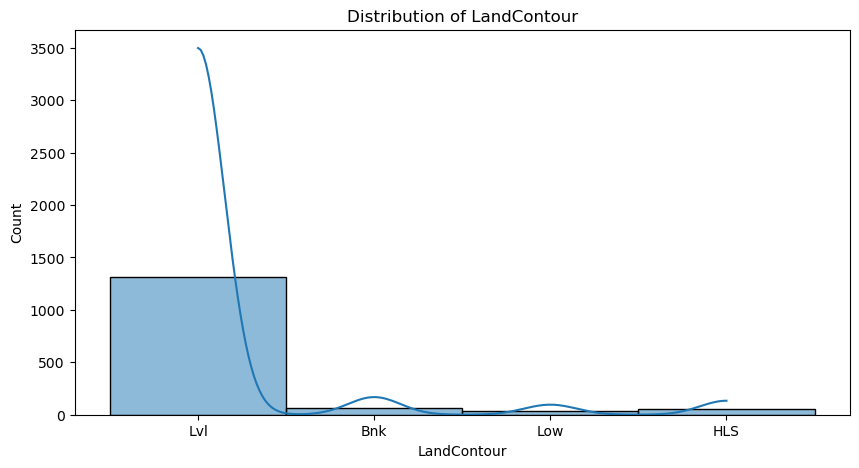

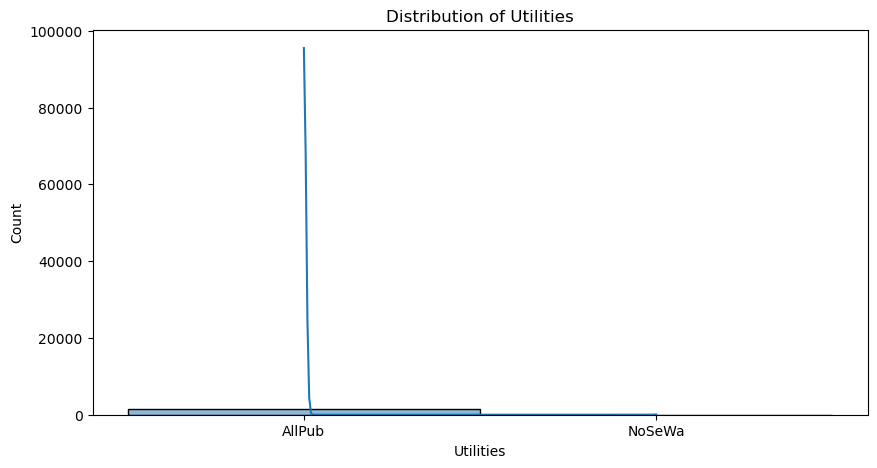

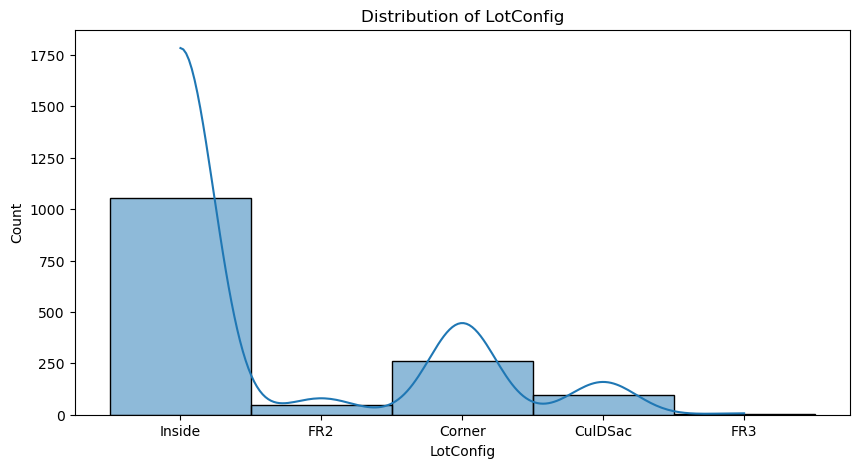

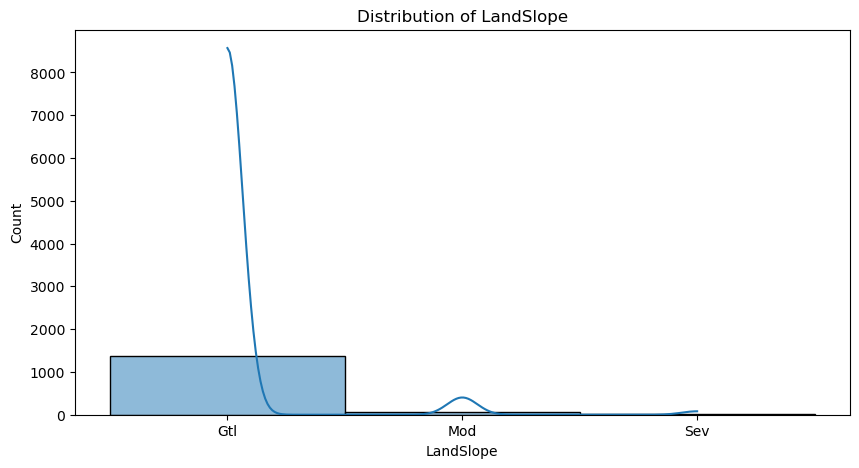

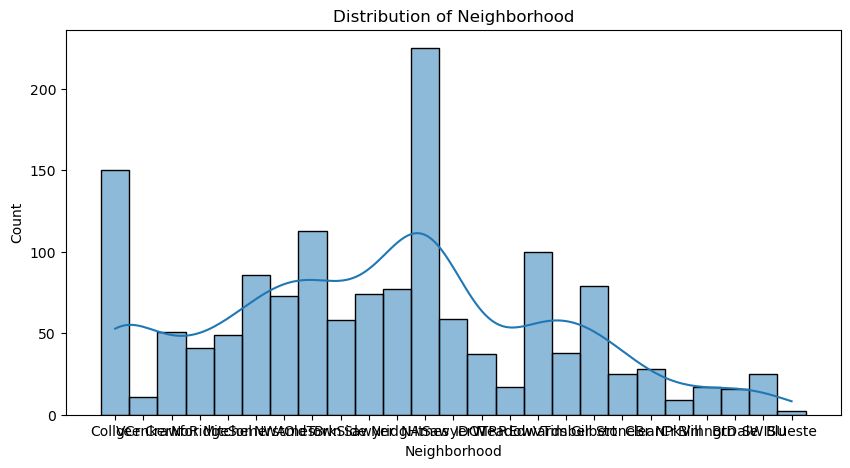

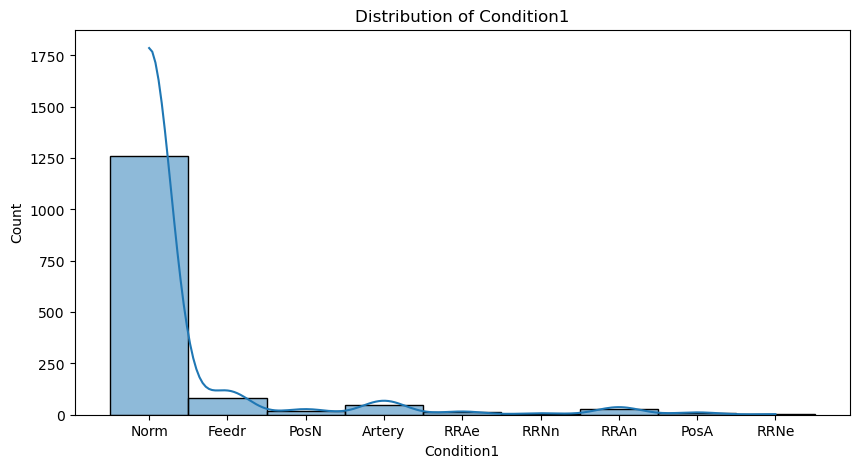

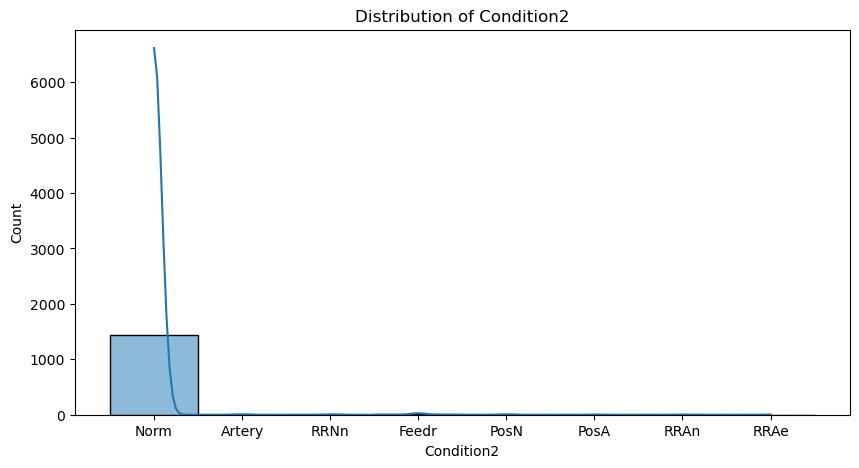

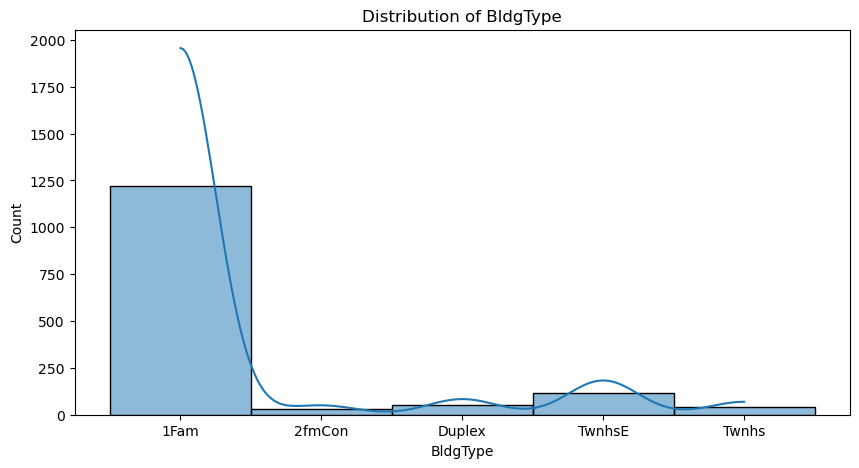

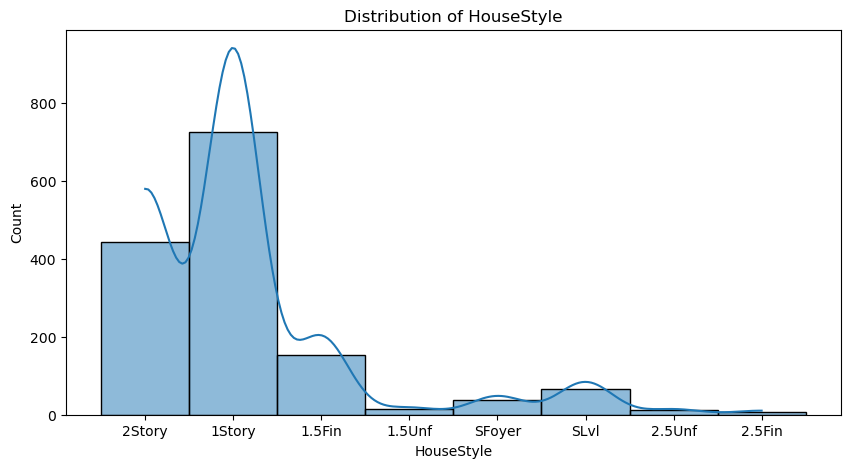

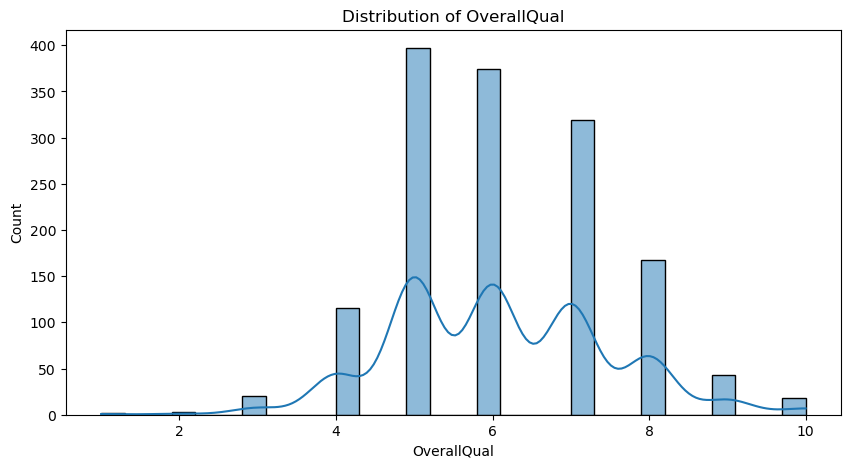

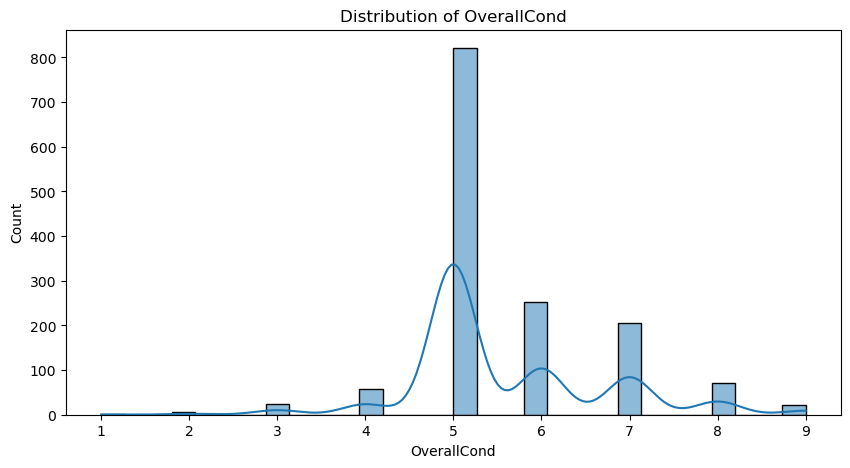

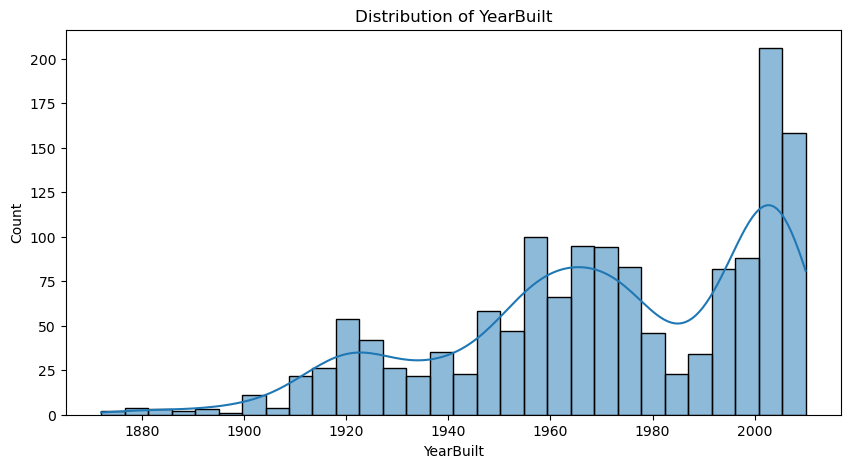

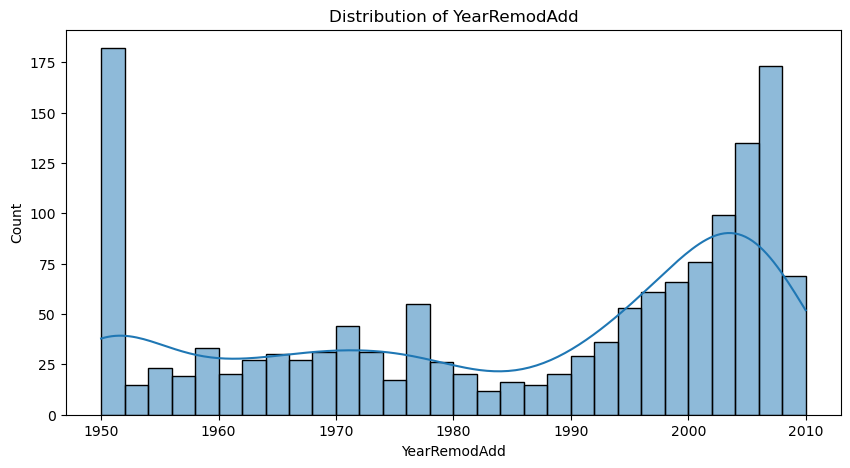

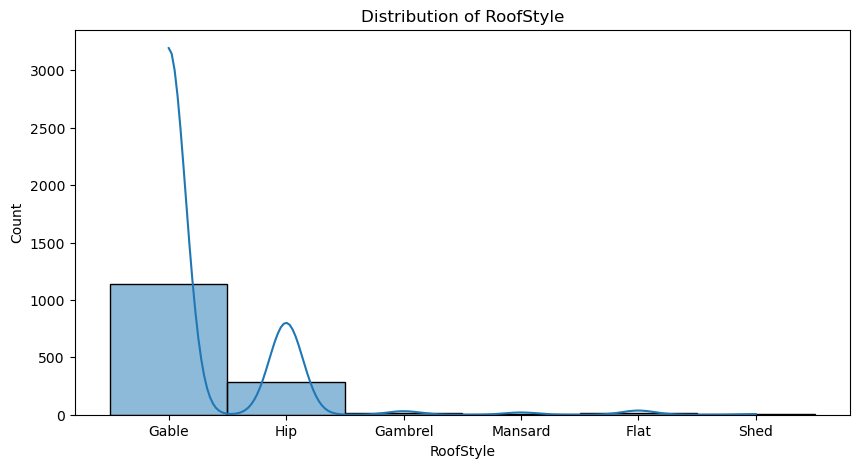

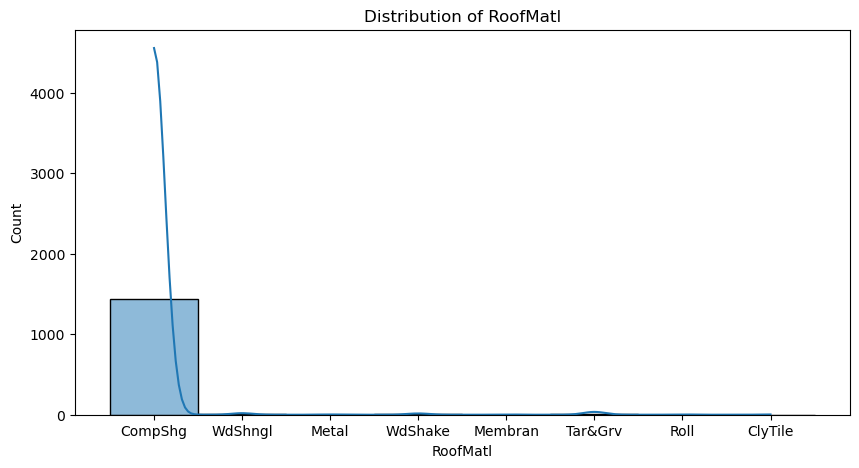

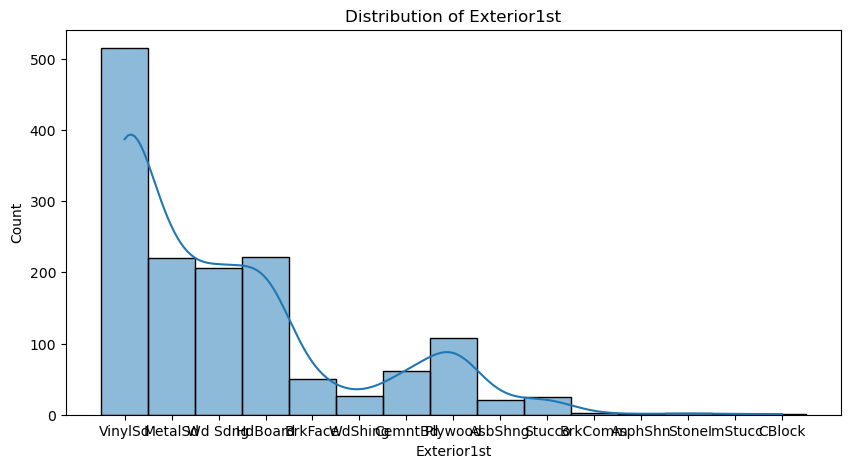

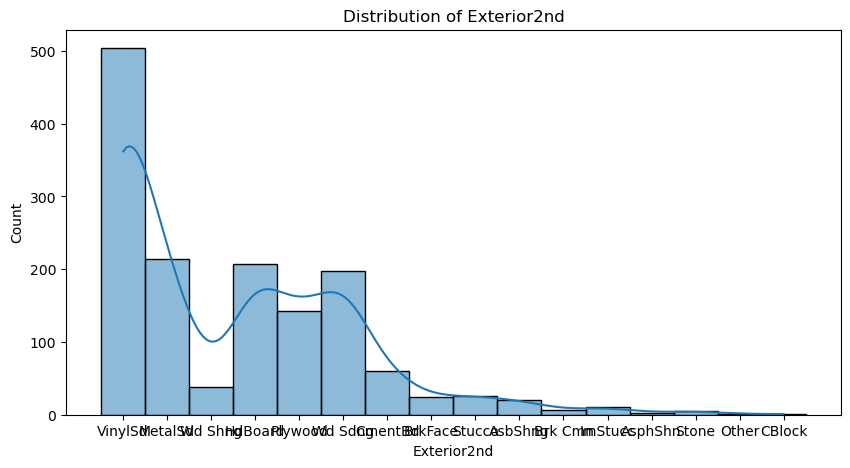

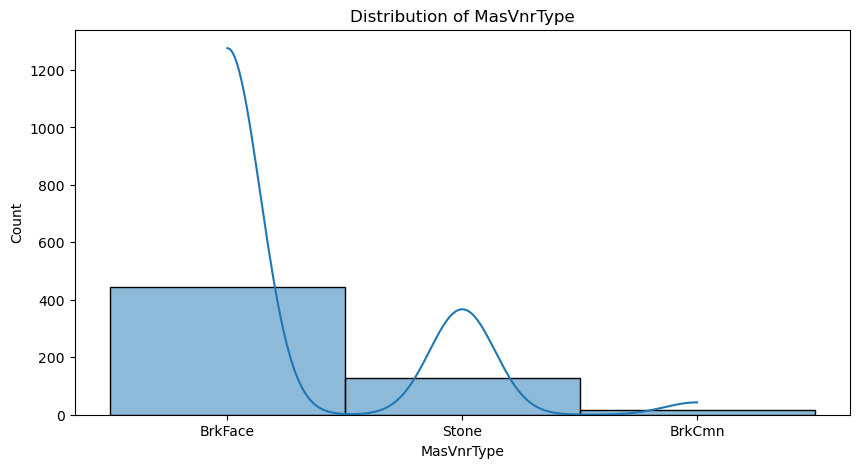

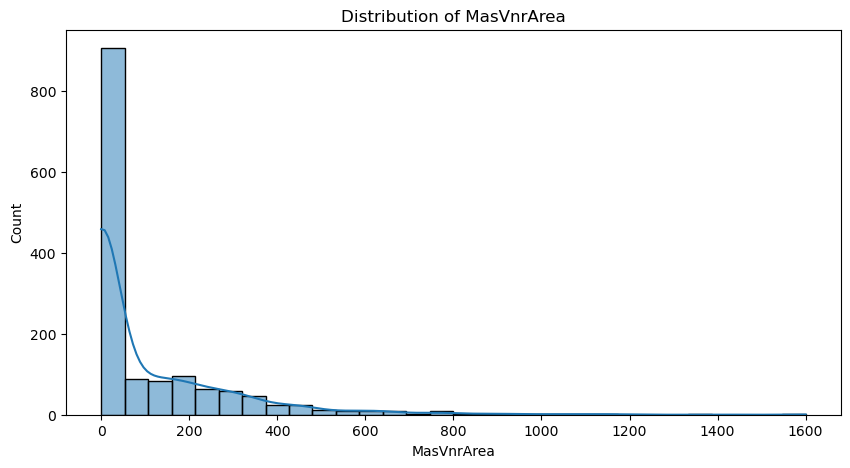

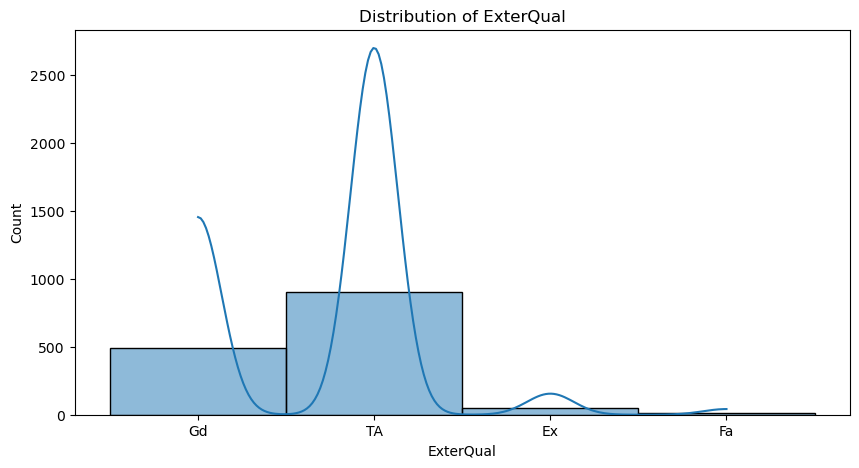

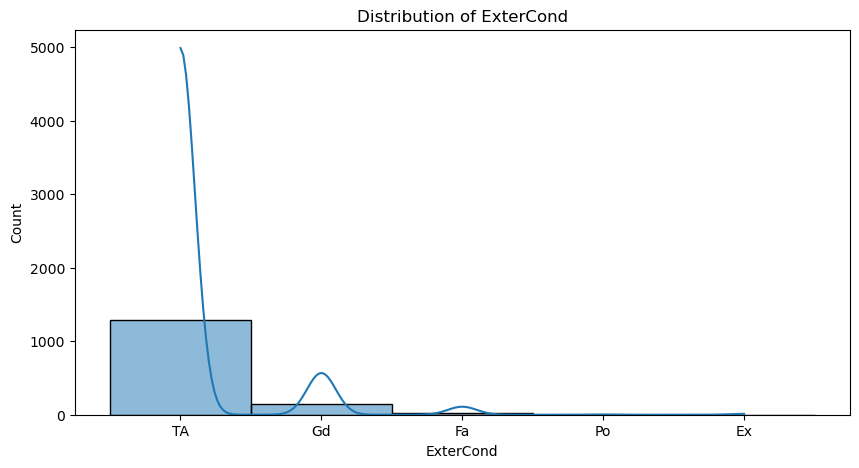

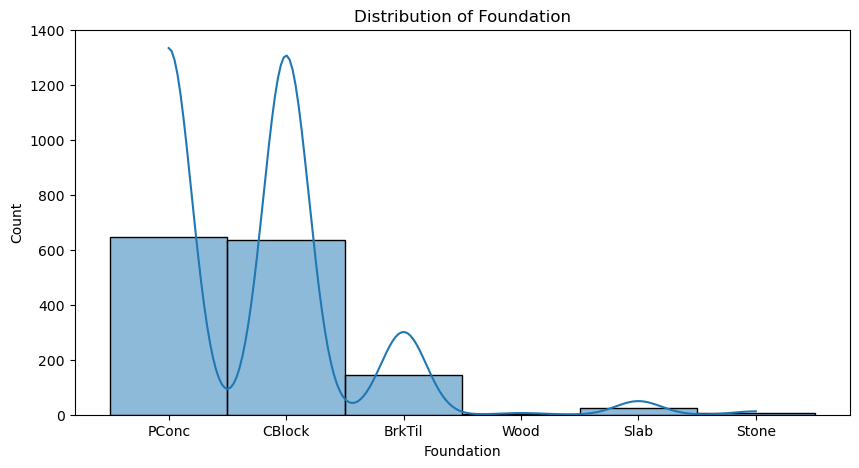

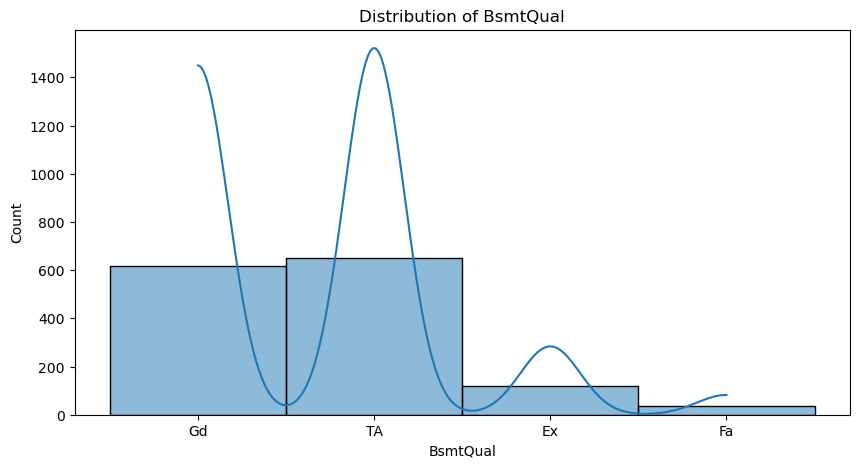

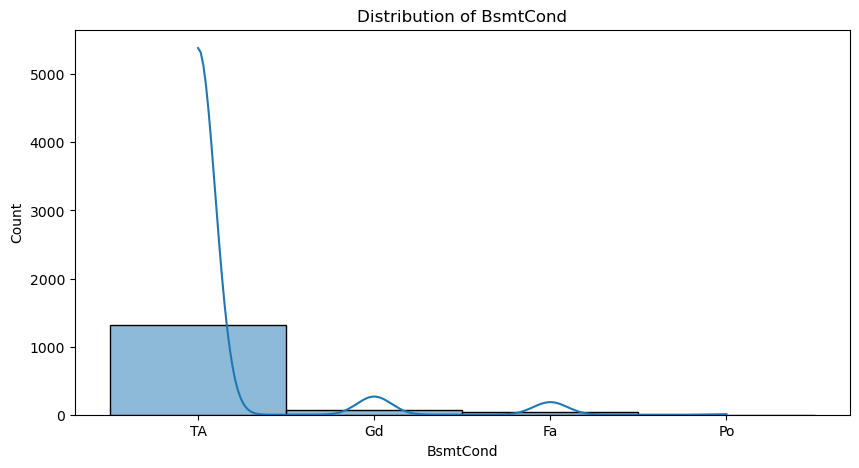

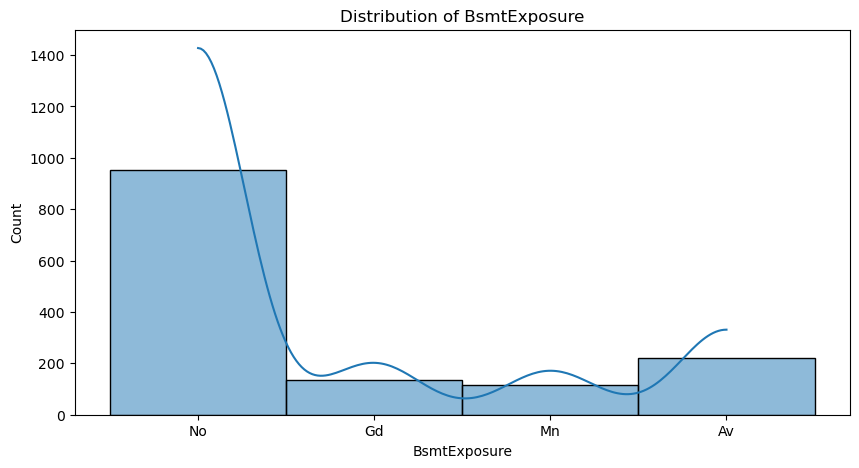

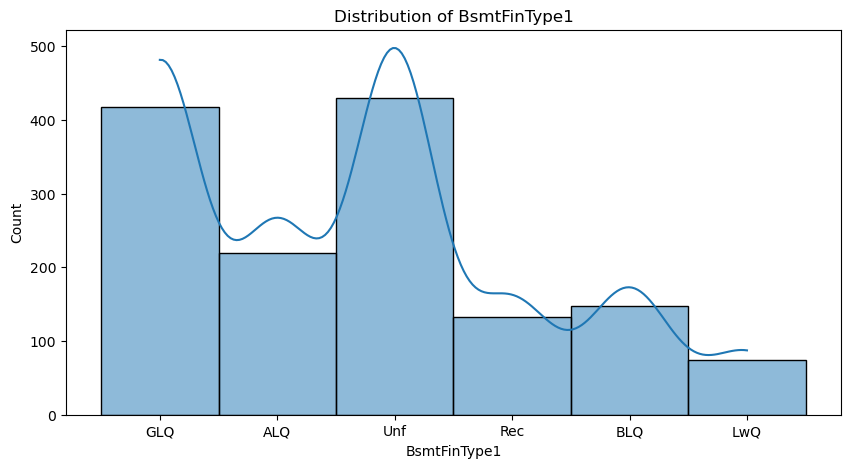

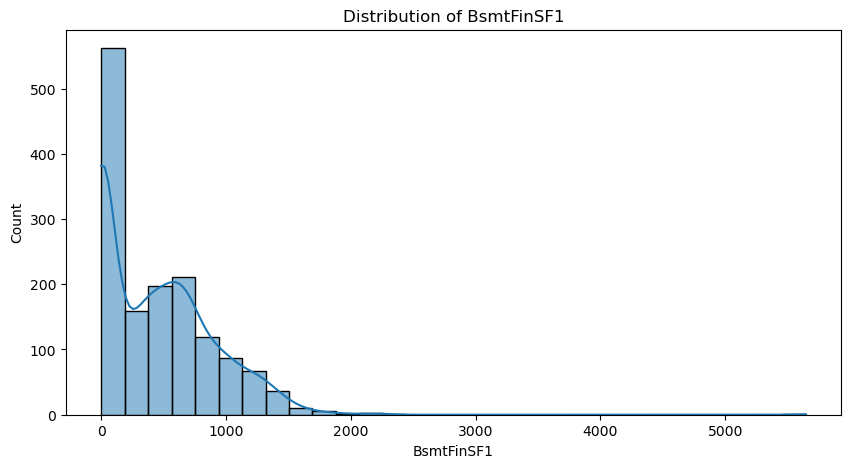

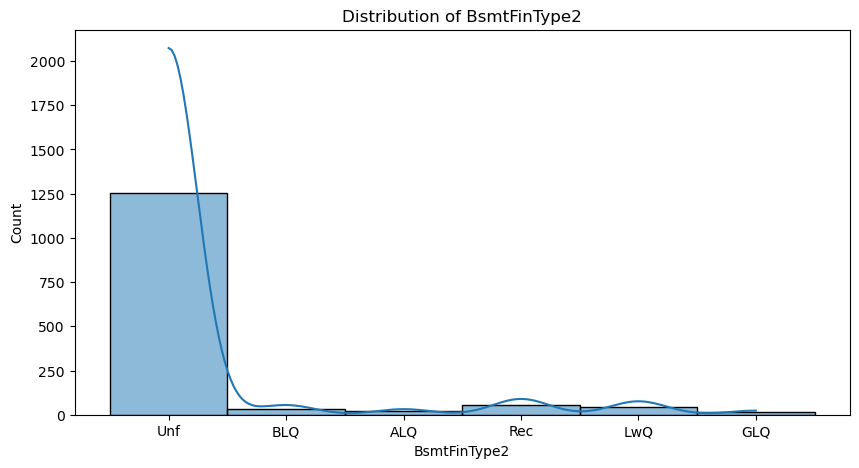

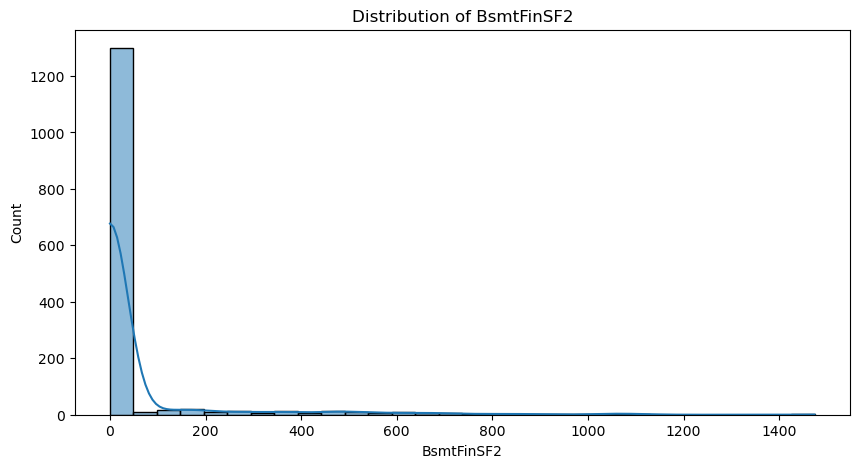

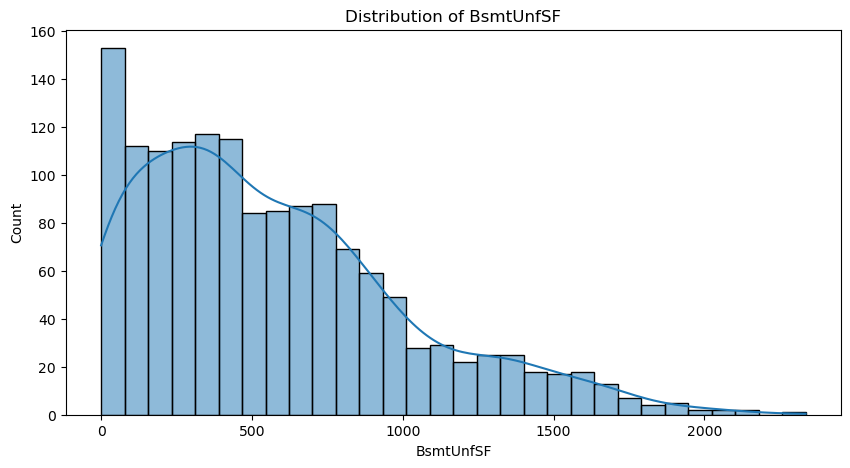

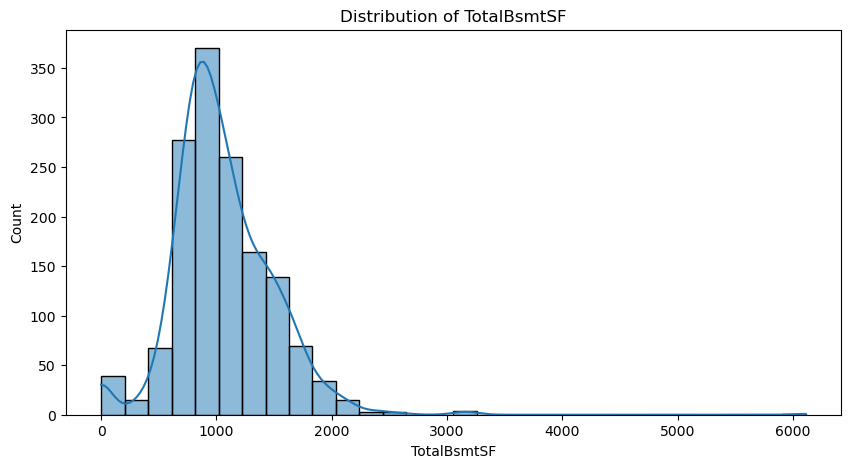

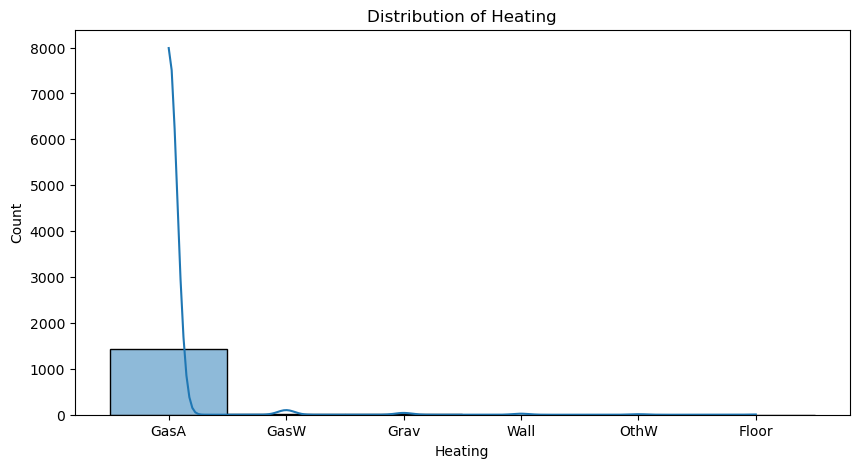

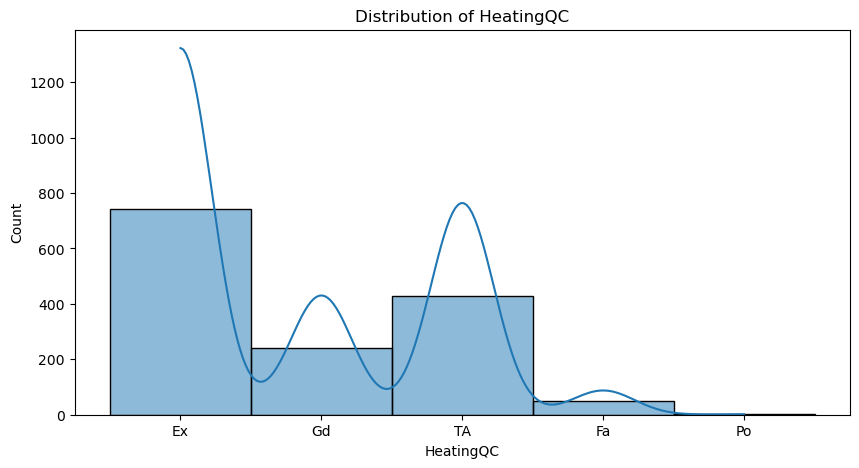

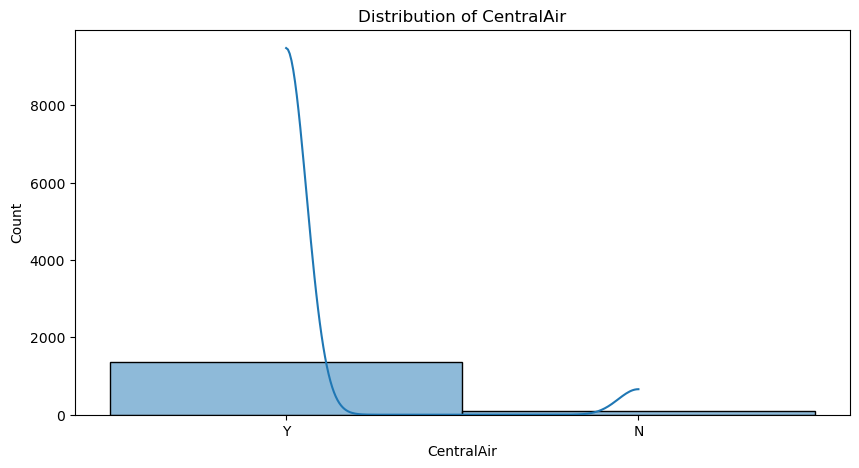

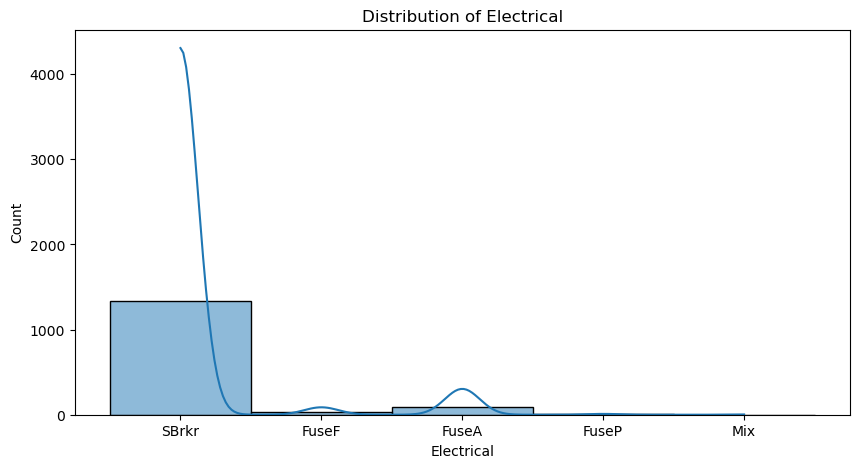

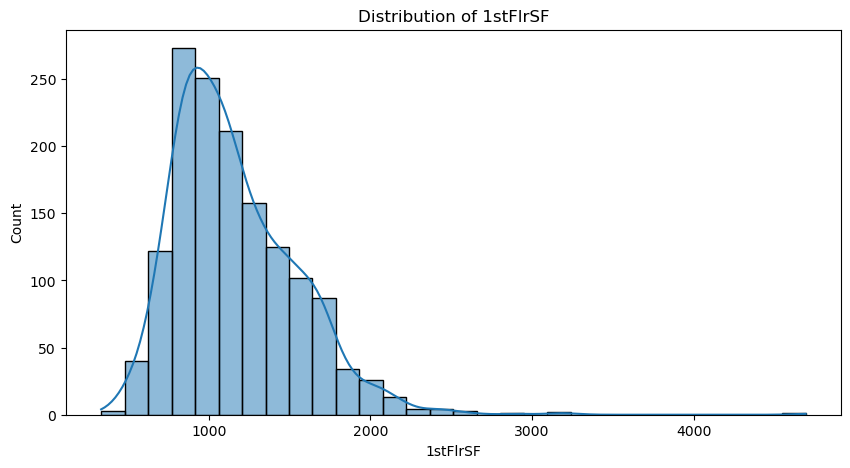

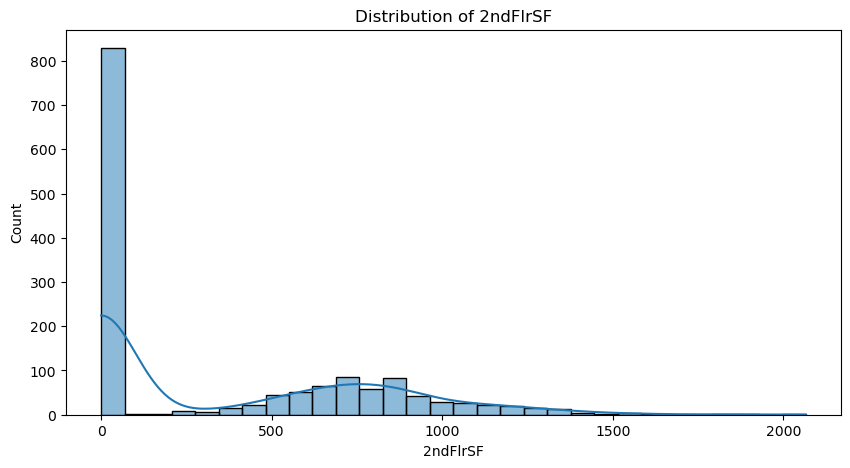

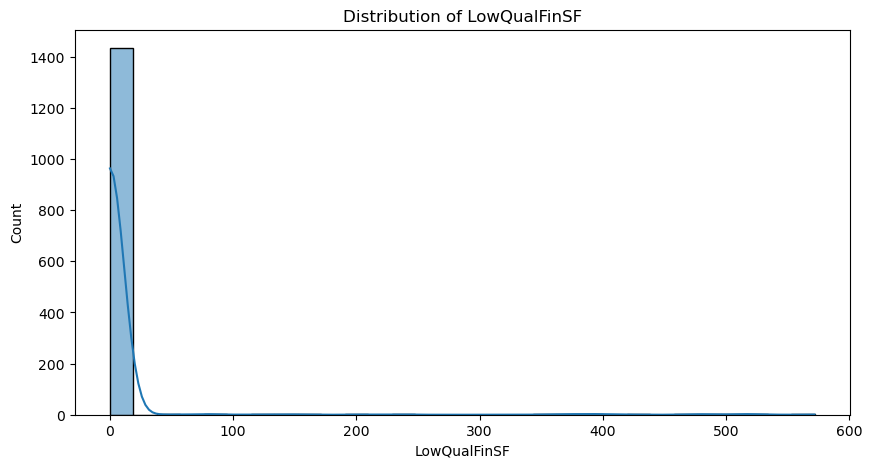

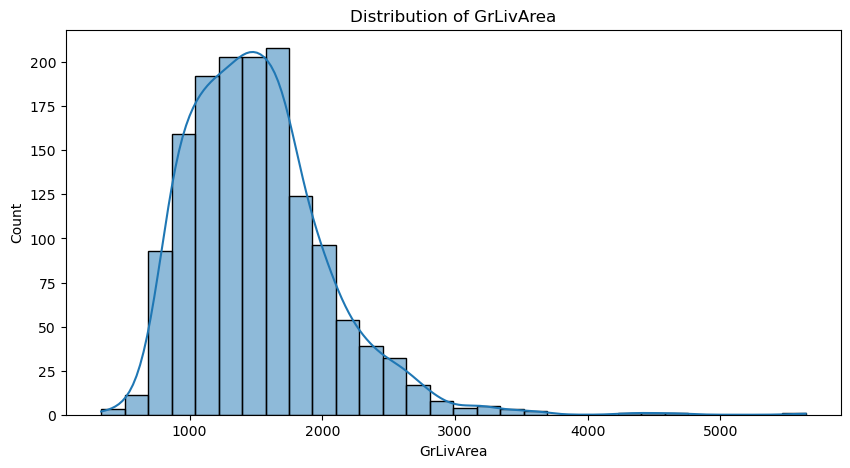

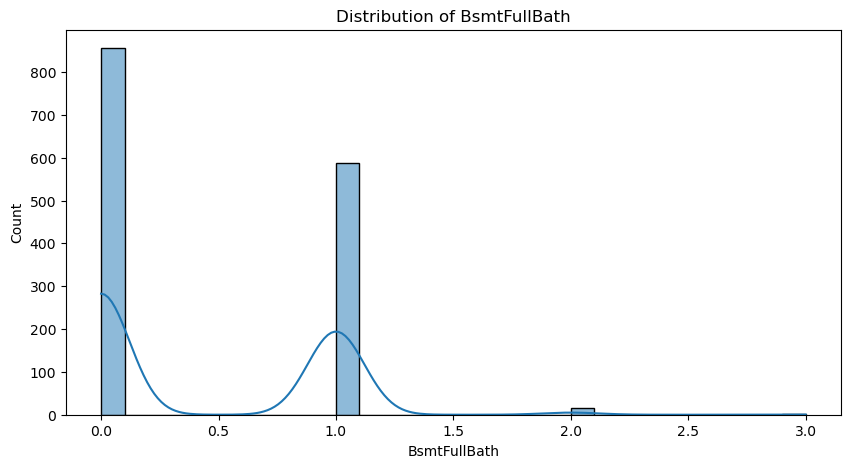

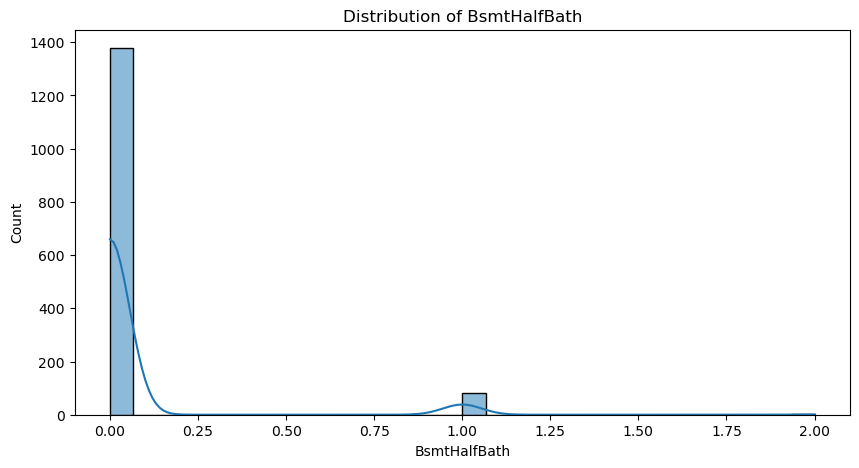

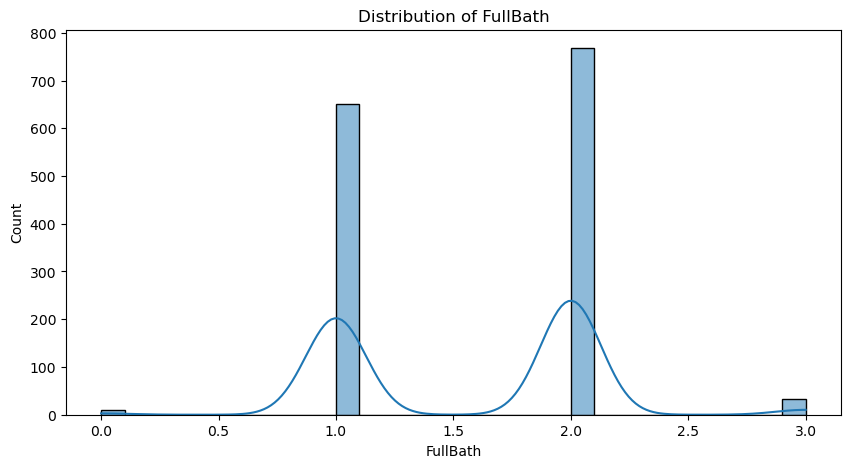

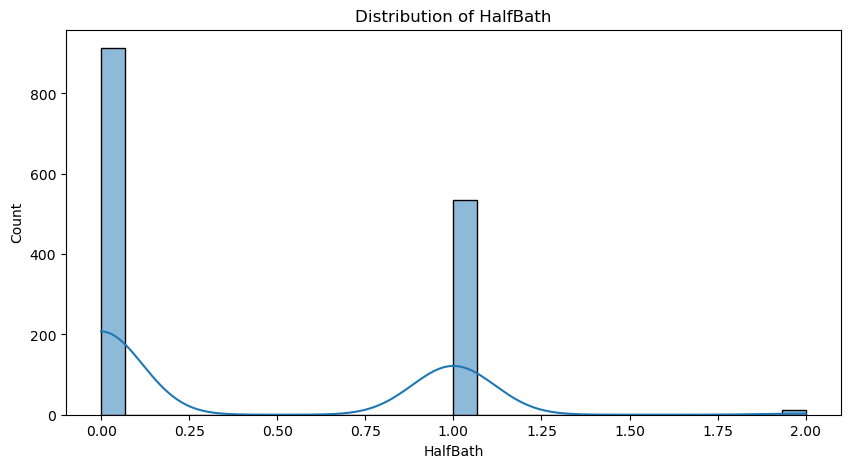

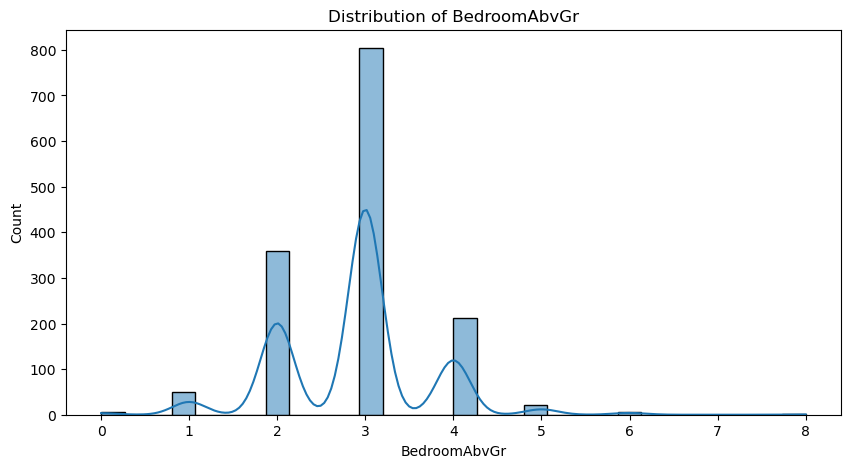

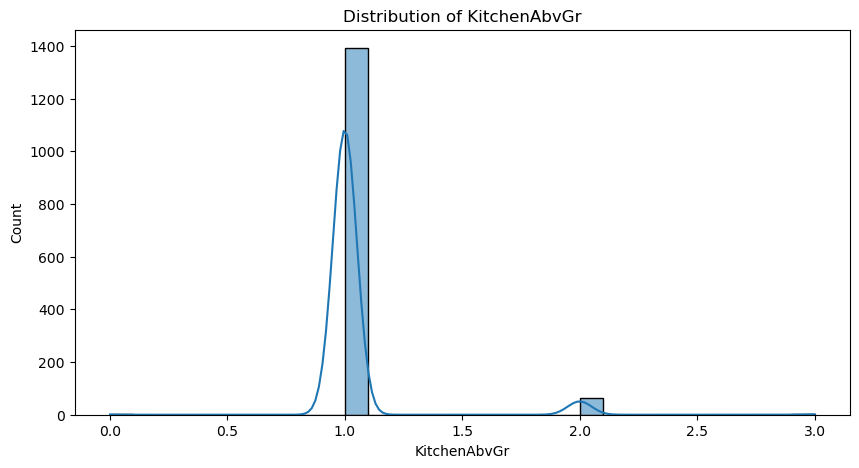

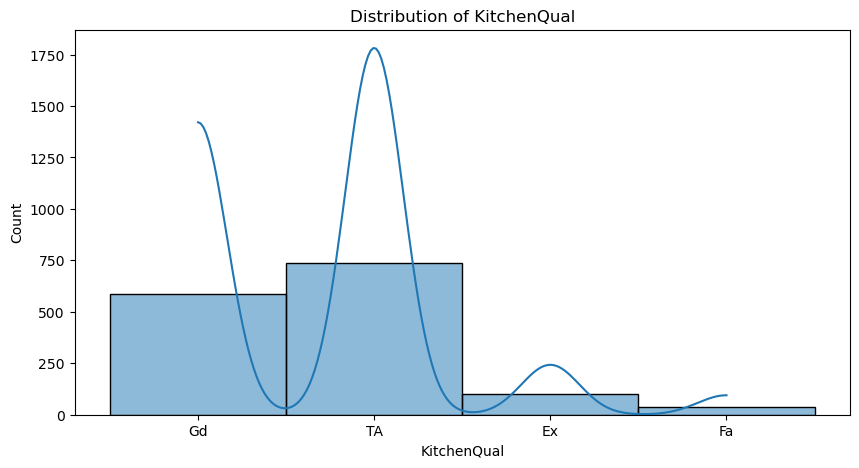

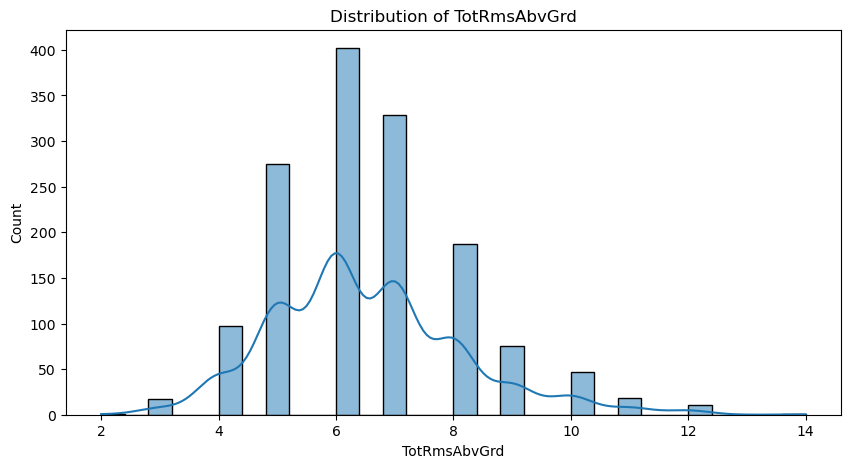

In [ ]:
#Represent the distribution of each feature using histograms
for col in df_train.columns:
    if col not in ['id']:
        plt.figure(figsize=(10, 5))
        sns.histplot(df_train['{}'.format(col)], bins=30, kde=True)
        plt.title('Distribution of {}'.format(col))
        plt.xlabel('{}'.format(col))
        plt.show()

In [ ]:
#Look at missing values per features
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

In [ ]:
#Remove features with more than 40% of null values
df_train.drop(columns = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu'], inplace=True)

In [ ]:
#Input missing values
#For the garage or basement features, the percentage of null values is really low. 
#As a result we will make the assumption that if the data is missing values for those features then there is no garage or basement on the property.
#We can therefore replace null values by zero or none for those features

for i in range(0,len(missing_data)):
    column = missing_data.index[i]
    if missing_data['Percent'][i] < 0.40:
        if missing_data['Percent'][i] > 0:
            if df_train[column].dtype == 'object':
                df_train[column].fillna(value = 'None', inplace=True)
            if df_train[column].dtype != 'object':
                df_train[column].fillna(value = 0 , inplace=True)

In [ ]:
#List categorical vs numerical features
categorical_cols = [col for col in df_train.columns if df_train[col].dtype == 'object']
numerical_cols = [col for col in df_train.columns if df_train[col].dtype != 'object']
numerical_cols.remove('SalePrice') # target variable
numerical_cols.remove('Id') # primary key of dataset

In [ ]:
#Create X and y datasets (no need to have X_train and X_test since we will use cross validations later) 
X = df_train.drop(columns = ['SalePrice', 'Id'])
y = df_train.SalePrice

In [ ]:
#Create Xgboost model with default parameters
#Note the XGBoost handles well missing value so we could have skipped the step which inputs missing values
model = XGBRegressor()

In [ ]:
#Create data pipeline

numerical_transformer = SimpleImputer(strategy='constant')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])

my_pipeline1 = Pipeline(steps = [('preprocessor', preprocessor), ('model', model)])

my_pipeline1.fit(X, y)

In [ ]:
#Apply cross validation with cv = 5
scores = -1 * cross_val_score(my_pipeline1, X, y, cv=5,scoring='neg_root_mean_squared_error')
print("RMSE scores:\n", scores)
print("Average RMSE score :")
print(scores.mean())

In [ ]:
#Input missing values in submission dataset and remove certain features

#Remove features
df_submission.drop(columns = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu'], inplace=True)

#Calculate null percentages
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

#Input missing values
for i in range(0,len(missing_data)):
    column = missing_data.index[i]
    if missing_data['Percent'][i] < 0.40:
        if missing_data['Percent'][i] > 0:
            if df_submission[column].dtype == 'object':
                df_submission[column].fillna(value = 'None', inplace=True)
            if df_submission[column].dtype != 'object':
                df_submission[column].fillna(value = 0 , inplace=True)


In [ ]:
#Make predictions
pred1 = my_pipeline1.predict(df_submission)
output = pd.DataFrame({"Id":df_submission.Id,"SalePrice":pred1})
output.to_csv('house_price_submission.csv', index=False)